<a href="https://colab.research.google.com/github/DrakeCS167Fall22/cs167fall22project2-messerli-wallace/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project #2
##Name: Jack Messerli-Wallace

Proposed Points (out of 25): 25

# 1. Problem
State the problem you are trying to solve with this machine learning experiment. Include a description of the data, where you got the data, and what you're trying to predict..

The problem I'm trying to solve is to classify mushroom types as edible (not poisonous) or not edible (poisonous) based on various qualitative and quantitative factors. My attempt at classification will be done with TensorFlow Keras multi-layer neural networks.

The data is from the following link (Kaggle):

https://www.kaggle.com/datasets/devzohaib/mushroom-edibility-classification

The data has 20 features to be used for classification. Columns describe mushroom appearance and size via different factors having to do with the mushroom cap, stem, and more.

# 2. Data Preparation
Explain your data preparation. What did you have to do to get your data in shape for your experiments? Why are you certain that you data is clean and prepared for use in your algorithms?

*First is to load the dataset.*

In [1]:
# load and prepare your data here
from google.colab import drive
import pandas as pd
import pandas
drive.mount('/content/drive')
data= pd.read_csv('/content/drive/MyDrive/CS_Class_Files/Datasets/mushroom/secondary_data.csv',delimiter=';')
data.head()

Mounted at /content/drive


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


*I then import modules and check the runtime type.*

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import keras
print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

import warnings
warnings.filterwarnings('ignore')

Found GPU at: /device:GPU:0
TensorFlow version: 2.9.2
Keras version: 2.9.0


In [3]:
import numpy
import keras
import sys
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
import sys

*I start preparing the data by removing useless data, starting by checking for null values.*

In [4]:
data.isna().any()

class                   False
cap-diameter            False
cap-shape               False
cap-surface              True
cap-color               False
does-bruise-or-bleed    False
gill-attachment          True
gill-spacing             True
gill-color              False
stem-height             False
stem-width              False
stem-root                True
stem-surface             True
stem-color              False
veil-type                True
veil-color               True
has-ring                False
ring-type                True
spore-print-color        True
habitat                 False
season                  False
dtype: bool

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

In [6]:
not_usable_columns = ['cap-surface','gill-attachment','gill-spacing','stem-root','stem-surface','veil-type','veil-color','spore-print-color']
data.drop(not_usable_columns, axis=1, inplace=True)

*The .info() call allows me to see how many non-null values we have in each column, such that I can figure out which features to drop versus impute. Below I describe why I dropped the columns above and what I'm doing with the other columns with null-values.*

*'cap-surface' has roughly 2/3 non-null values, but from data inspection has too many different possible values (which are categorical), so I made the call to drop this column*

*'gill-attachment' has roughly 5/6 non-null values, but some of the non-null values include unknown values (denoted by '?'). This column is dropped for this reason.*

*'gill-spacing', 'stem-root', 'stem-surface', 'veil-type', 'veil-color', and 'spore-print-color' are all columns with half or less of the values being non-null, so they have been dropped.*

*'ring-type' has only a few thousand null-values, so the following cells will be dealing with fixing that column.*

In [7]:
data['ring-type'].value_counts()

f    48361
e     2435
z     2118
l     1427
r     1399
p     1265
g     1240
m      353
Name: ring-type, dtype: int64

*Because 'f' comprises a majority of the values, it will be used to fill the NaN values.*

In [8]:
data['ring-type'].fillna(value='f',inplace=True)

In [9]:
#double checking that the previous call worked
data['ring-type'].isna().any()

False

*Now that the null values have been handled, it is time to turn the string-based columns into number based columns. This will be done by creating dummy variables and by replacing strings representing boolean values with 0's and 1's.*

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-color             61069 non-null  object 
 4   does-bruise-or-bleed  61069 non-null  object 
 5   gill-color            61069 non-null  object 
 6   stem-height           61069 non-null  float64
 7   stem-width            61069 non-null  float64
 8   stem-color            61069 non-null  object 
 9   has-ring              61069 non-null  object 
 10  ring-type             61069 non-null  object 
 11  habitat               61069 non-null  object 
 12  season                61069 non-null  object 
dtypes: float64(3), object(10)
memory usage: 6.1+ MB


*'class' is the target variable and has values of 'p' and 'e' (denoting poisonous and edible respectively). Values of 'p' will be 1 while 'e' will be 0, making the classification problem a question of "if the mushroom is poisonous or not".*

*'cap-shape', 'cap-color', 'gill-color', 'stem-color', 'ring-type', 'habitat', and 'season' are all categorical and will be handled with one-hot encoding.*

*'does-bruise-or-bleed', 'has-ring' can be represented with boolean (binary) values, just like 'class'.*

*Below is the implementation of these conclusions, done using pandas function calls.*

In [11]:
#class first
data['class'].replace(to_replace=['p','e'], value=[1,0], inplace=True)

#other boolean columns
data['does-bruise-or-bleed'].replace(to_replace=['t','f'], value=[1,0], inplace=True)
data['has-ring'].replace(to_replace=['t','f'], value=[1,0], inplace=True)

#dummies
data = pd.get_dummies(data=data, columns=['cap-shape', 'cap-color', 'gill-color', 'stem-color', 'ring-type', 'habitat', 'season'])

#check the data
data.head()

,class,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,has-ring,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,...,habitat_h,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w
0,1,15.26,0,16.95,17.09,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,16.60,0,17.99,18.19,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,14.07,0,17.80,17.74,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,14.17,0,15.77,15.98,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1,14.64,0,16.53,17.20,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


*The next step is to create the test and train split, done using Sklearn's train_test_split.*

In [12]:
from sklearn.model_selection import train_test_split

target_variable = 'class'
predictors = data.columns.drop(target_variable) #everything but class

train_data, test_data, train_sln, test_sln = train_test_split(data[predictors], 
                                                                  data[target_variable], test_size=0.2, random_state=1)

*After splitting the data, the continuous columns are scaled with Sklearn's StandardScalar. Note that the scalar is fit on the training data and applied to the training and test data for consistency.*

In [13]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(copy=False)

#continuous numeric columns
cols_continuous = ['cap-diameter','stem-height','stem-width']


#fit the scalar for training data
scalar.fit(train_data[cols_continuous])

#scale both test and train data on the scalar fit for the training data
train_normalized = scalar.transform(train_data[cols_continuous])
test_normalized = scalar.transform(test_data[cols_continuous])

*Next I make our data usable in Keras models. I learned some strategies to do this via the TensorFlow tutorial page.
https://www.tensorflow.org/tutorials/load_data/pandas_dataframe.*

*The important thing to note is that Keras cannot take a dataframe as input, so our data must be converted into a tensorflow tensor.*

In [14]:
train_data = tf.convert_to_tensor(train_data)
test_data = tf.convert_to_tensor(test_data)

train_sln = tf.convert_to_tensor(train_sln)
test_sln = tf.convert_to_tensor(test_sln)

*Now that we have the training and testing sets in terms that Keras can understand, we can begin our research.*

# 3. Research

Put your code and your experiments here.

*My initial test will be done on a "default" model, with two hidden layers trained on the default Adam optimizer. Please note that in all of these tests, multiple runs are done to make sure results are consistent and replicable. The only runs that are shown are those I deemed fit to lead me into the next step of changing the model.*

In [40]:
# code goes here... don't forget to include graphs. Professor Urness loves graphs.
from keras.metrics import Accuracy

n_features = train_data.shape[1] #input number for dimensions of the neural network

model = Sequential()
#hidden layers
model.add(Dense(64, input_dim=n_features, activation='relu'))
model.add(Dense(64, activation='relu'))
#output layer
model.add(Dense(1))

# Compile model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                4480      
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________


In [41]:
training_results = model.fit(
        x=train_data,
        y=train_sln,
        epochs=20, #number of epochs 
        validation_data = (test_data, test_sln), #to get test accuracy for each epoch
        verbose = 0 #No output to reduce the amount of total text
        )

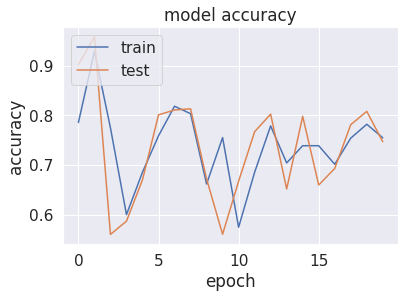

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(training_results.history['accuracy'])
plt.plot(training_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

*The default learning rate sems to be too high, or the model needs to be trained further to converge. My next attempts will increase the number of epochs and change the learning rate of the optimizer. Note that the type of optimizer (Adam) will not be changed.*

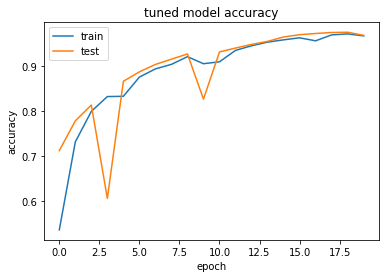

In [18]:
n_features = train_data.shape[1] #input number for dimensions of the neural network

model_tuned = Sequential()
#hidden layers
model_tuned.add(Dense(64, input_dim=n_features, activation='relu'))
model_tuned.add(Dense(64, activation='relu'))
#output layer
model_tuned.add(Dense(1))

# Compile model
model_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #default learning rate is 0.001
              loss='binary_crossentropy', metrics=['accuracy'])

training_results = model_tuned.fit(
        x=train_data,
        y=train_sln,
        epochs=20, #number of epochs 
        validation_data = (test_data, test_sln), #to get test accuracy for each epoch
        verbose = 0 #no output
        )

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(training_results.history['accuracy'])
plt.plot(training_results.history['val_accuracy'])
plt.title('tuned model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

*Next is to examine how the model changes with varying layer size and amount. My goal is to make the smallest overall size coverge with a high accuracy. I will adjust node number, hidden layer amount (if applicable), activation functions, and epochs.*

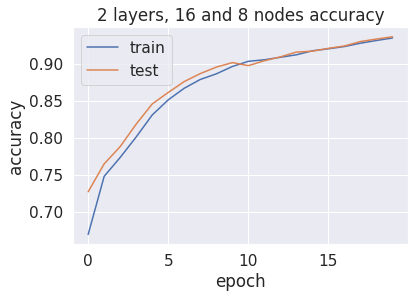

In [28]:
n_features = train_data.shape[1] #input number for dimensions of the neural network

model_tuned = Sequential()

#hidden layers
model_tuned.add(Dense(16, input_dim=n_features, activation='relu'))
model_tuned.add(Dense(8, activation='relu'))

#output layer
model_tuned.add(Dense(1, activation='sigmoid'))

# Compile model
model_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), #default learning rate is 0.001
              loss='binary_crossentropy', metrics=['accuracy'])

training_results = model_tuned.fit(
        x=train_data,
        y=train_sln,
        epochs=20, #number of epochs 
        validation_data = (test_data, test_sln), #to get test accuracy for each epoch
        verbose = 0 #no output
        )

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(training_results.history['accuracy'])
plt.plot(training_results.history['val_accuracy'])
plt.title('2 layers, 16 and 8 nodes accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

382/382 [==============================] - 1s 3ms/step


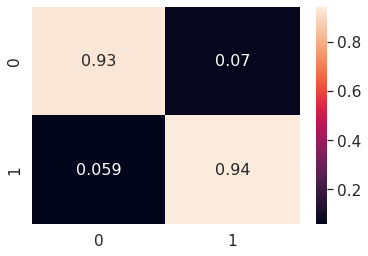

In [39]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt


#get prediction for matrix
prediction = model_tuned.predict(test_data)

#Set values such that we have binary instead of floats, dividing at 0.5 per the sigmoid activation function
for i in range(len(prediction)):
  if prediction[i][0] >= 0.5:
    prediction[i][0] = 1
  else:
    prediction[i][0] = 0



result = confusion_matrix(test_sln, prediction, normalize='true')


df_cm = pd.DataFrame(result, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

*The above model has the best balance of factors and a confusion matrix to fit. Below is where I finally reach a point where it takes longer for the accuracy to increase.*

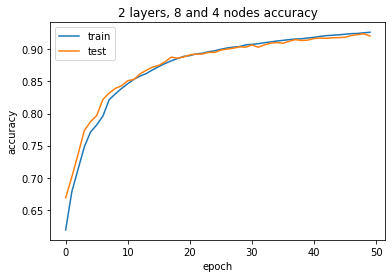

In [20]:
n_features = train_data.shape[1] #input number for dimensions of the neural network

model_tuned = Sequential()

#hidden layers
model_tuned.add(Dense(8, input_dim=n_features, activation='relu'))
model_tuned.add(Dense(4, activation='relu'))

#output layer
model_tuned.add(Dense(1, activation='sigmoid'))

# Compile model
model_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), #default learning rate is 0.001
              loss='binary_crossentropy', metrics=['accuracy'])

training_results = model_tuned.fit(
        x=train_data,
        y=train_sln,
        epochs=50, #number of epochs 
        validation_data = (test_data, test_sln), #to get test accuracy for each epoch
        verbose = 0 #no output
        )

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(training_results.history['accuracy'])
plt.plot(training_results.history['val_accuracy'])
plt.title('2 layers, 8 and 4 nodes accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

*Adding in more layers does not change the accuracy by much, as shown in the next model. More nodes are needed per layer and fewer layers works.*

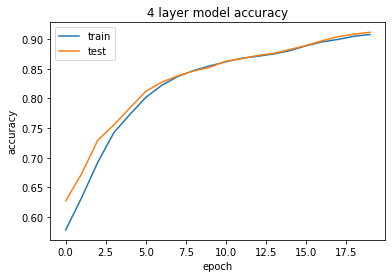

In [21]:
n_features = train_data.shape[1] #input number for dimensions of the neural network

model_tuned = Sequential()

#hidden layers
model_tuned.add(Dense(6, input_dim=n_features, activation='relu'))
model_tuned.add(Dense(4, activation='relu'))
model_tuned.add(Dense(4, activation='relu'))
model_tuned.add(Dense(2, activation='relu'))

#output layer
model_tuned.add(Dense(1, activation='sigmoid'))

# Compile model
model_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), #default learning rate is 0.001
              loss='binary_crossentropy', metrics=['accuracy'])

training_results = model_tuned.fit(
        x=train_data,
        y=train_sln,
        epochs=20, #number of epochs 
        validation_data = (test_data, test_sln), #to get test accuracy for each epoch
        verbose = 0 #no output
        )

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(training_results.history['accuracy'])
plt.plot(training_results.history['val_accuracy'])
plt.title('4 layer model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#4. Analysis

What did you discover? What insights/recommendations do you have? What did you find that was interesting? Which model was your best model, which models didn't work well? Why do you think this is? In general, I want a discussion of your experiment, the results, and what they mean.

*A smaller number of layers and nodes than expected are needed to make a multi-layer perceptron model converge for this dataset. Training time was similar for models of various sizes. I was surprised that changing the number of nodes in each layer didn't significantly change the training time. Epoch number was the variable that significantly changed the model training time, which is not surprising.*

*My plan for optimizing the model was to first optimize the learning rate and epoch amount for a "default" model, then change layer number, size, and activation to see how efficient I could make the model.*

*My initial models used two layers with 64 nodes, as we had worked on that scale for some previous exercises. After optimizing the learning rate, I dropped the node number until it took noticeably longer for the model to converge. The point where things started being less accurate was two layers with 8 and 4 nodes, which reached just above 90% accuracy after 50 epochs, while the original model (two layers at 64 nodes each) took 20 epochs to reach over 95% accuracy. The middle ground that I believe to be close to optimal is two layers with 16 and 8 nodes trained on 20 epochs. This model has a similar accuracy to the larger models and converges in the same amount of time and epochs. This was my best model.*

*My results suggest that the data is separable by a few factors and that the correlation between those factors is simple enough to be trained on two layers. In terms of the problem, we can be fairly confident (about 95% confident) in this model when deciding whether a certian mushroom type is poisnonous.*

# 5. Bumps in the Road
What challenges did you encounter? How did you overcome these challenges?

*I had the most bumps in the road during data preparation, as it was the section that took me the most time. Deciding what data to keep and use was a struggle I figured out via looking through the pandas documentation, where I then was able to use the info() call to analyze the data. Making the data able to be used in the Keras models was my biggest struggle in data preaparation. The solution was to convert the dataframes to tensors, but coming up with that took several documentation sites and Stack Overflow posts.*

*Formatting my models in the Keras library was a task one could consider a sturggle, due to the troubleshooting it took. Reading through our previous class examples helped a bit, but I had to read through several documentation sites to figure out how to change things for my problem.*

*Overall, I overcame my challenges by reading documentation and paying special attention to detail when giving function arguments.*